# Notebook for enriching protein-biological process and drug-biological process edges

In our MOA project, we want to use the [Gene Ontology Biological Process](http://geneontology.org/docs/ontology-documentation/) (BP) as sink nodes, so we need to incorporate this information into the KG.

In [1]:
import pandas as pd
from tqdm import tqdm
import os.path as osp

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# Load enriched KG file

In [2]:
KG_DIR = '../data/kg/'

In [3]:
full_kg = pd.read_csv(osp.join(KG_DIR, 'enriched_kg.tsv'), sep='\t')

Get all of the true drug-BP pairs:

In [4]:
true_pairs = [(row['source'], row['target']) for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()]

Get all of the proteins which go to BPs:

In [5]:
bps_in_pairs = {row['target'] for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()}

prots_to_bps = set()

# get the proteins which interact with those BPs
for i, row in full_kg.loc[(full_kg['edge_type'] == 'participates') & (full_kg['target'].isin(bps_in_pairs))].iterrows():
    prots_to_bps.add((row['source']))

len(prots_to_bps)

1816

Add all of the forward PPIs:

In [6]:
G = nx.DiGraph()

for i, row in full_kg.iterrows():
    if row['edge_type'] == 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

Here, we subset the PPIs in the graph until they are below the limit. We do this systematically by removing PPIs from high-degree edges.

In [7]:
PPI_LIMIT = 12000

In [8]:
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]
count = 0

while G.number_of_edges() > PPI_LIMIT:
    prot_with_highest_degree = max(prot_nodes, key=lambda n: G.out_degree(n))
    # Find the neighbor of prot_with_highest_degree with the largest degree
    neighbor_of_highest_degree = max([node for node in nx.neighbors(G,prot_with_highest_degree) if node in prot_nodes],
                                      key=lambda n: G.out_degree(n))
    # remove the edge between prot_with_highest_degree and neighbor_of_highest_degree
    G.remove_edge(prot_with_highest_degree, neighbor_of_highest_degree)
    count += 1
    if count % 1000 == 0:
        print(count, G.number_of_edges())

1000 36984
2000 35984
3000 34984
4000 33984
5000 32984
6000 31984
7000 30984
8000 29984
9000 28984
10000 27984
11000 26984
12000 25984
13000 24984
14000 23984
15000 22984
16000 21984
17000 20984
18000 19984
19000 18984
20000 17984
21000 16984
22000 15984
23000 14984
24000 13984
25000 12984


Let's see which proteins are left with a degree of zero:

In [9]:
prots_with_0_degree = [node for node in prot_nodes if G.degree(node) == 0]
len(prots_with_0_degree)

761

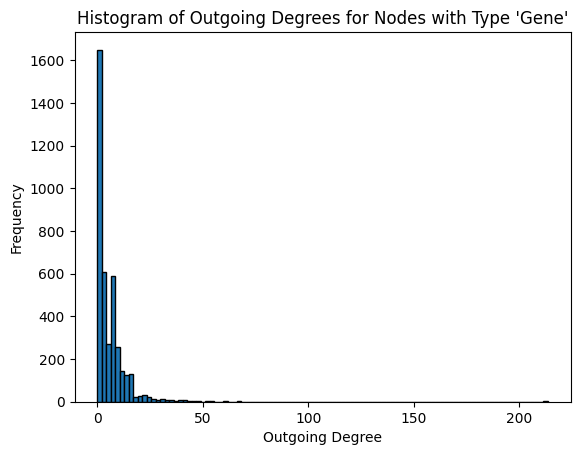

In [10]:
# Filter nodes based on type
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.degree(node) for node in prot_nodes]

# Plot histogram
plt.hist(out_degrees, bins=100, range=(0, max(out_degrees) + 0.5), edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Gene'")
plt.show()

In [11]:
degrees = dict(Counter(out_degrees))

for d in sorted(degrees)[0:150]:
    print(d, degrees[d])

0 761
1 575
2 313
3 216
4 392
5 146
6 124
7 144
8 444
9 162
10 96
11 88
12 54
13 63
14 61
15 42
16 49
17 40
18 10
19 14
20 12
21 13
22 12
23 19
24 8
25 12
26 9
27 6
28 3
29 3
30 6
31 5
32 3
33 3
34 4
35 2
36 4
37 2
38 3
39 7
40 1
41 2
42 4
43 1
44 1
45 3
46 2
47 1
49 2
50 1
52 3
53 2
54 1
55 2
59 1
60 1
61 2
65 1
68 2
85 1
100 1
197 1
213 3


We will remove those isolated nodes.

In [12]:
# remove isolated nodes
def remove_isolated_nodes(G):

    # remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    
    return G

In [13]:
G = remove_isolated_nodes(G)

Add in the other edges:

In [14]:
for i, row in full_kg.iterrows():
    if row['edge_type'] != 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

In [15]:
isolated_nodes = list(nx.isolates(G))
len(isolated_nodes)

0

Get all the protein nodes which are not connected to a GO BP or drug:

In [16]:
protein_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'Gene']

filtered_protein_nodes = set()

for protein_node in protein_nodes:
    neighbors = G.neighbors(protein_node)
    leave_alone = bool(set(neighbors) & prots_to_bps)  # if it has neighbors 
    if leave_alone:
        continue
    
    neighbor_types = [G.nodes[neighbor].get('type') for neighbor in neighbors]
    
    if 'Compound' not in neighbor_types and 'Biological Process' not in neighbor_types:
        filtered_protein_nodes.add(protein_node)

In [17]:
len(filtered_protein_nodes)

2218

Now remove these:

In [18]:
edges_to_remove = []

for edge in G.edges():
    source_node, target_node = edge
    if source_node in filtered_protein_nodes or target_node in filtered_protein_nodes:
        edges_to_remove.append(edge)

G.remove_edges_from(edges_to_remove)

In [19]:
G = remove_isolated_nodes(G)

In [20]:
isolated_nodes = list(nx.isolates(G))
len(isolated_nodes)

0

In [21]:
# export G to pandas df with node types
G_df = nx.to_pandas_edgelist(G, edge_key='edge_type')

In [22]:
G_df.rename(columns={'type': 'edge_type'}, inplace=True)

In [23]:
G_df

,source,target,edge_type
0,ncbigene:6622,ncbigene:3308,interacts
1,ncbigene:6622,GO:0043065,participates
2,ncbigene:3308,GO:0006457,participates
3,ncbigene:4804,ncbigene:2885,interacts
4,ncbigene:4804,ncbigene:3265,interacts
...,...,...,...
9807,pubchem.compound:38853,GO:0006520,induces
9808,pubchem.compound:38853,GO:0006629,induces
9809,pubchem.compound:38853,GO:0007005,induces
9810,pubchem.compound:38853,GO:0006259,induces


In [24]:
def map_to_nodetype(id):
    if 'ncbigene:' in id:
        return 'Gene'
    elif 'GO:' in id:
        return 'Biological Process'
    elif 'pubchem' in id:
        return 'Compound'
    else:
        raise ValueError(f'Unknown node type for {id}')

In [25]:
G_df['source_node_type'] = [map_to_nodetype(i) for i in G_df['source']]
G_df['target_node_type'] = [map_to_nodetype(i) for i in G_df['target']]

In [26]:
G_df

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
2,ncbigene:3308,GO:0006457,participates,Gene,Biological Process
3,ncbigene:4804,ncbigene:2885,interacts,Gene,Gene
4,ncbigene:4804,ncbigene:3265,interacts,Gene,Gene
...,...,...,...,...,...
9807,pubchem.compound:38853,GO:0006520,induces,Compound,Biological Process
9808,pubchem.compound:38853,GO:0006629,induces,Compound,Biological Process
9809,pubchem.compound:38853,GO:0007005,induces,Compound,Biological Process
9810,pubchem.compound:38853,GO:0006259,induces,Compound,Biological Process


In [27]:
Counter(G_df['edge_type'])

Counter({'interacts': 5264,
         'induces': 1675,
         'participates': 1314,
         'downregulates': 841,
         'upregulates': 718})

But we've got to take out any drug-BP pairs which can no longer be matched:

In [28]:
edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if 'type' in data and data['type'] == 'induces']
G.remove_edges_from(edges_to_remove)

In [29]:
no_path = set()

for pair in true_pairs:
    path_exists = nx.has_path(G, pair[0], pair[1])
    if not path_exists:
        no_path.add(pair)

print(len(no_path))

752


In [30]:
len(true_pairs)

1675

In [31]:
len(no_path) / len(true_pairs)

0.448955223880597

In [32]:
for i, row in G_df.iterrows():
    if row['edge_type'] == 'induces' and (row['source'], row['target']) in no_path:
        print(f"Dropping {(row['source'], row['target'])}")
        G_df.drop(i, inplace=True)

Dropping ('pubchem.compound:10607', 'GO:0007017')
Dropping ('pubchem.compound:10607', 'GO:0022607')
Dropping ('pubchem.compound:10607', 'GO:0048646')
Dropping ('pubchem.compound:10607', 'GO:0008219')
Dropping ('pubchem.compound:10607', 'GO:0030705')
Dropping ('pubchem.compound:10607', 'GO:0050877')
Dropping ('pubchem.compound:10607', 'GO:0021700')
Dropping ('pubchem.compound:10607', 'GO:0022618')
Dropping ('pubchem.compound:10631', 'GO:0002376')
Dropping ('pubchem.compound:10631', 'GO:0007017')
Dropping ('pubchem.compound:10631', 'GO:0008219')
Dropping ('pubchem.compound:10631', 'GO:0008283')
Dropping ('pubchem.compound:10631', 'GO:0021700')
Dropping ('pubchem.compound:10631', 'GO:0030154')
Dropping ('pubchem.compound:10631', 'GO:0030705')
Dropping ('pubchem.compound:10631', 'GO:0032880')
Dropping ('pubchem.compound:10631', 'GO:0042592')
Dropping ('pubchem.compound:10631', 'GO:0043085')
Dropping ('pubchem.compound:10631', 'GO:0048646')
Dropping ('pubchem.compound:10631', 'GO:0048856')


In [33]:
Counter(G_df['edge_type'])

Counter({'interacts': 5264,
         'participates': 1314,
         'induces': 923,
         'downregulates': 841,
         'upregulates': 718})

In [34]:
G_df

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
2,ncbigene:3308,GO:0006457,participates,Gene,Biological Process
3,ncbigene:4804,ncbigene:2885,interacts,Gene,Gene
4,ncbigene:4804,ncbigene:3265,interacts,Gene,Gene
...,...,...,...,...,...
9794,pubchem.compound:457193,GO:0007010,induces,Compound,Biological Process
9795,pubchem.compound:457193,GO:0016192,induces,Compound,Biological Process
9796,pubchem.compound:457193,GO:0043065,induces,Compound,Biological Process
9797,pubchem.compound:457193,GO:0006397,induces,Compound,Biological Process


In [35]:
G_df.to_csv(osp.join(KG_DIR, 'full_kg.tsv'), sep='\t', index=False)